## Set up software libraries
Authenticate and import as necessary.

In [ ]:
# Cloud authentication.
from google.colab import auth
auth.authenticate_user()

In [ ]:
# Import, authenticate and initialize the Earth Engine library.
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=1QAwF26EGCMqMBG1IBYm8o5N6__kRNJVCGK1uphm-Ns&tc=2-rrJyLVpBSUSjM2ZvLoh_HJA-DHIDXUGArVQnUjvQs&cc=Fy3WvOw_9eOkOmEMeZsX0QOuCyDX5UqjuVXuhX9OSSY

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AWtgzh4ZAQps40F5LXNpwNXHI5Pog76bg4WFx-f0ZyzonrTA7GpZbKkg3hM

Successfully saved authorization token.


In [ ]:
# Tensorflow setup.
import tensorflow as tf
print(tf.__version__)

2.11.0


# Set variables

Specify variables regarding observation time of the satellite imagery, thresholds for melt detection and additional parameters requiered for the U-Net model preparation.

In [ ]:
# Time period of interest
start = ee.Date('2016-01-01')
end = ee.Date('2021-12-31')

# Winter months
winter_start = 6
winter_end = 8

# Thresholds
threshold_s0_dB = 3
threshold_s0_float = ee.Number(10).pow(ee.Number(-3).multiply(0.1))
threshold_Tb_K = 30

# Additional parameters
scale_spatialres = 500
crs_3031 = 'epsg:3031'
kernel_size = 64

# Area of interest
Select the area of interest for collection of training and evaluation data. When the entire Antarctic Ice Sheet is considered, this step can be ignored.

In [ ]:
# This is a small polygon over Shackelton Ice Shelf

ROI = ee.Geometry.Polygon(
        [[[91.9847043233891, -64.89182613902013],
          [91.9847043233891, -67.13238301545371],
          [105.6516965108891, -67.13238301545371],
          [105.6516965108891, -64.89182613902013]]])

# Four testing regions on the Shackleton Ice Shelf
R1 = ee.FeatureCollection("users/sophiederoda/UNet_SpatialPredictiveAnalyses/Region1_clipped").geometry()
R2 = ee.FeatureCollection("users/sophiederoda/UNet_SpatialPredictiveAnalyses/Region2_clipped").geometry()
R3 = ee.FeatureCollection("users/sophiederoda/UNet_SpatialPredictiveAnalyses/Region3_clipped").geometry()
R4 = ee.FeatureCollection("users/sophiederoda/UNet_SpatialPredictiveAnalyses/Region4_clipped").geometry()

# Prepocess data
The reference data (i.e., Sentinel-1 binary melt) and input features (i.e., ASCAT, SSMIS, elevation, Sentinel-1 monthly average) were preprocessed, according to the steps presented in the figure below.

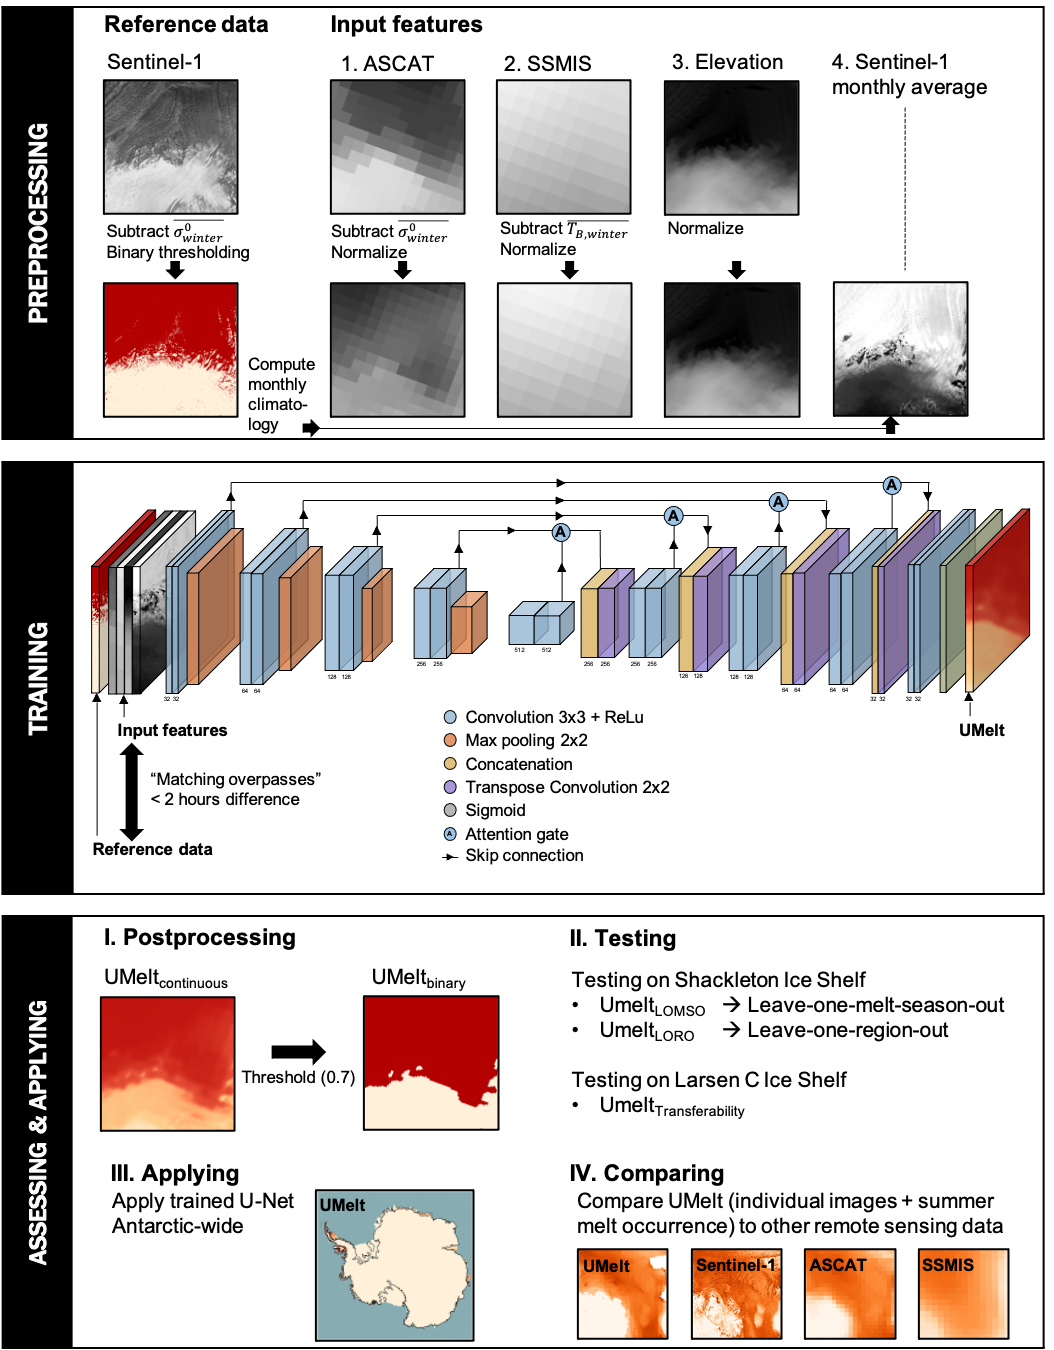

## Import satellite data

### Active and passive microwave data

In [ ]:
S1_collection = ee.ImageCollection("COPERNICUS/S1_GRD_FLOAT")

ascat_collection = ee.ImageCollection("users/aardmapp/Antarctica/ascat")
ascat_collection2 = ee.ImageCollection("users/sderodahusman2/ascat")

SSMIS_2016 = ee.ImageCollection("users/sderodahusman/SSMIS_F17_19H_2016")
SSMIS_2017 = ee.ImageCollection("users/sderodahusman/SSMIS_F17_19H_2017")
SSMIS_2018 = ee.ImageCollection("users/sderodahusman/SSMIS_F17_19H_2018")
SSMIS_2019 = ee.ImageCollection("users/sderodahusman/SSMIS_F17_19H_2019")
SSMIS_2020 = ee.ImageCollection("users/sderodahusman/SSMIS_F17_19H_2020")
SSMIS_2021 = ee.ImageCollection("users/sderodahusman/SSMIS_F17_19H_2021")

### Elevation

In [ ]:
# Import REMA mosaic (REMA elevation and its derived slope are used as predictors for the U-Net)
REMA = ee.Image("users/sophiederoda/GeneralAntarcticData/REMA_200m_dem_filled").rename('elevation')

# Reproject DEM and slope
DEM = REMA.reproject(**{'crs': crs_3031, 'scale': scale_spatialres})

## Sentinel-1

### (1) Preprocessing

In [ ]:
# Fuction to add local overpass time time to properties
def localTime(img):
    geometry_centr = ee.Feature(img.geometry()).centroid()
    centroidInfo = img.int().reduceToVectors(**{'geometry': geometry_centr.geometry(), 'scale': 10, 'maxPixels': 1e10, 'geometryType': "centroid", 'tileScale': 16})
    lon = centroidInfo.geometry().coordinates().get(0)
    localtime = img.date().advance(ee.Number(lon).divide(15), 'hour')
    localtime_millis = ee.Date(localtime).millis()
    return img.set('LocalTime',localtime_millis)

# Function to compute area of footprint (to later remove areas having a footprint < 100 km2,
# since these are 'slice' images that give errors when computing coordinates in 'localTime' function)
def areaFootprint(img):
    area = img.geometry().area().divide(1000 * 1000)
    return img.set('area', area)

# Function to mask areas > 1700 m (no melt expected)
def maskHighElevation(img):
    masked = img.updateMask(DEM.lt(1700))
    return masked

# Preprocessed Sentinel-1 image collection
S1 = S1_collection \
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', 'HH')) \
    .select('HH') \
    .filterDate(start, end) \
    .filterBounds(ROI) \
    .map(localTime) \
    .map(areaFootprint) \
    .filterMetadata('area','greater_than', 100) \
    .map(maskHighElevation)

# Transfrom backscatter from log to dB units
def transformTodB(img):
    return img.log10().multiply(10).rename(['HH_dB']).copyProperties(img, ["LocalTime"]);
S1_dB = S1.map(transformTodB)

print('Sentinel-1 collection:', S1.first().getInfo())
print('Number of Sentinel-1 images:', S1.size().getInfo())

Sentinel-1 collection: {'type': 'Image', 'bands': [{'id': 'HH', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [16043, 15358], 'crs': 'EPSG:32747', 'crs_transform': [40, 0, 64854.39561463363, 0, -40, 3056721.1820455743]}], 'id': 'COPERNICUS/S1_GRD_FLOAT/S1A_EW_GRDM_1SDH_20170604T132550_20170604T132655_016884_01C15B_A0AB', 'version': 1547473956610520.0, 'properties': {'area': 178268.87581194163, 'LocalTime': 1496605917532, 'SNAP_Graph_Processing_Framework_GPF_vers': '6.0.4', 'SLC_Processing_facility_org': 'ESA', 'SLC_Processing_facility_country': 'United Kingdom', 'GRD_Post_Processing_facility_org': 'ESA', 'transmitterReceiverPolarisation': ['HH', 'HV'], 'GRD_Post_Processing_start': 1496587589210, 'sliceNumber': 1, 'GRD_Post_Processing_facility_name': 'Copernicus S1 Core Ground Segment - UPA', 'resolution': 'M', 'SLC_Processing_facility_name': 'Copernicus S1 Core Ground Segment - UPA', 'system:footprint': {'type': 'LinearRing', 'coordinates': [[95.06233679607507

### (2) Binary melt computation

In [ ]:
S1_base = S1

# Select winter months for each year of interest
S1_2017_winter = S1_base.filterDate('2016-06-01', '2016-08-31')
S1_2018_winter = S1_base.filterDate('2017-06-01', '2017-08-31')
S1_2019_winter = S1_base.filterDate('2018-06-01', '2018-08-31')
S1_2020_winter = S1_base.filterDate('2019-06-01', '2019-08-31')
S1_2021_winter = S1_base.filterDate('2020-06-01', '2020-08-31')

# Extract available orbits (in winter months)
S1_2017_orbits = ee.Dictionary(S1_2017_winter.aggregate_histogram('relativeOrbitNumber_start')).keys()
S1_2018_orbits = ee.Dictionary(S1_2018_winter.aggregate_histogram('relativeOrbitNumber_start')).keys()
S1_2019_orbits = ee.Dictionary(S1_2019_winter.aggregate_histogram('relativeOrbitNumber_start')).keys()
S1_2020_orbits = ee.Dictionary(S1_2020_winter.aggregate_histogram('relativeOrbitNumber_start')).keys()
S1_2021_orbits = ee.Dictionary(S1_2021_winter.aggregate_histogram('relativeOrbitNumber_start')).keys()

# Melt years (defined from April-1 year N - March-31 year N+1)
S1_2017_year = S1_base.filterDate('2016-04-01', '2017-03-31')
S1_2018_year = S1_base.filterDate('2017-04-01', '2018-03-31')
S1_2019_year = S1_base.filterDate('2018-04-01', '2019-03-31')
S1_2020_year = S1_base.filterDate('2019-04-01', '2020-03-31')
S1_2021_year = S1_base.filterDate('2020-04-01', '2021-03-31')

# Functions for melt computations, per year and per orbit
def meltComputationS1_2017(orbit): #yearOfInterest
    S1_m = S1_2017_year.filter(ee.Filter.eq('relativeOrbitNumber_start', ee.Number.parse(orbit).toInt()))
    S1_w = S1_m.filter(ee.Filter.calendarRange(winter_start,winter_end,'month')).mean().min(ee.Image(5));
    S1_c = S1_m.map(lambda img: img.addBands(img.lt(S1_w.multiply(threshold_s0_float)).toFloat().rename('melt')))
    return S1_c.toList(S1_c.size())

S1_2017_melt = ee.ImageCollection.fromImages(S1_2017_orbits.map(meltComputationS1_2017).flatten()).select('melt')

def meltComputationS1_2018(orbit): #yearOfInterest
    S1_m = S1_2018_year.filter(ee.Filter.eq('relativeOrbitNumber_start', ee.Number.parse(orbit).toInt()))
    S1_w = S1_m.filter(ee.Filter.calendarRange(winter_start,winter_end,'month')).mean().min(ee.Image(5));
    S1_c = S1_m.map(lambda img: img.addBands(img.lt(S1_w.multiply(threshold_s0_float)).toFloat().rename('melt')))
    return S1_c.toList(S1_c.size())

S1_2018_melt = ee.ImageCollection.fromImages(S1_2018_orbits.map(meltComputationS1_2018).flatten()).select('melt')

def meltComputationS1_2019(orbit): #yearOfInterest
    S1_m = S1_2019_year.filter(ee.Filter.eq('relativeOrbitNumber_start', ee.Number.parse(orbit).toInt()))
    S1_w = S1_m.filter(ee.Filter.calendarRange(winter_start,winter_end,'month')).mean().min(ee.Image(5));
    S1_c = S1_m.map(lambda img: img.addBands(img.lt(S1_w.multiply(threshold_s0_float)).toFloat().rename('melt')))
    return S1_c.toList(S1_c.size())

S1_2019_melt = ee.ImageCollection.fromImages(S1_2019_orbits.map(meltComputationS1_2019).flatten()).select('melt')

def meltComputationS1_2020(orbit): #yearOfInterest
    S1_m = S1_2020_year.filter(ee.Filter.eq('relativeOrbitNumber_start', ee.Number.parse(orbit).toInt()))
    S1_w = S1_m.filter(ee.Filter.calendarRange(winter_start,winter_end,'month')).mean().min(ee.Image(5));
    S1_c = S1_m.map(lambda img: img.addBands(img.lt(S1_w.multiply(threshold_s0_float)).toFloat().rename('melt')))
    return S1_c.toList(S1_c.size())

S1_2020_melt = ee.ImageCollection.fromImages(S1_2020_orbits.map(meltComputationS1_2020).flatten()).select('melt')

def meltComputationS1_2021(orbit): #yearOfInterest
    S1_m = S1_2021_year.filter(ee.Filter.eq('relativeOrbitNumber_start', ee.Number.parse(orbit).toInt()))
    S1_w = S1_m.filter(ee.Filter.calendarRange(winter_start,winter_end,'month')).mean().min(ee.Image(5));
    S1_c = S1_m.map(lambda img: img.addBands(img.lt(S1_w.multiply(threshold_s0_float)).toFloat().rename('melt')))
    return S1_c.toList(S1_c.size())

S1_2021_melt = ee.ImageCollection.fromImages(S1_2021_orbits.map(meltComputationS1_2021).flatten()).select('melt')

# Merge all files
S1_melt = S1_2017_melt \
          .merge(S1_2018_melt) \
          .merge(S1_2019_melt) \
          .merge(S1_2020_melt) \
          .merge(S1_2021_melt)

S1_melt = S1_melt.select('melt')

# Only select dates in which melt is expected (Nov - March, Antarctic summer months)
S1_melt = S1_melt.filter(ee.Filter.calendarRange(11, 3 ,'month'))
print(S1_melt.size().getInfo())

1827


### (3) Reprojection

In [ ]:
# Reduce Sentinel-1 resolution to 500 m and reproject to EPGS:3031.
def reduceResolutionS1(feature):
  return feature.reproject(**{'crs': crs_3031, 'scale': scale_spatialres}).toInt();
S1_melt = S1_melt.map(reduceResolutionS1)

print('Sentinel-1 melt collection:', S1_melt.first().getInfo())
print('Number of Sentinel-1 melt images:', S1_melt.size().getInfo())

Sentinel-1 melt collection: {'type': 'Image', 'bands': [{'id': 'melt', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}], 'id': 'COPERNICUS/S1_GRD_FLOAT/S1A_EW_GRDM_1SSH_20161206T132547_20161206T132651_014259_017106_4199', 'version': 1548957599286598, 'properties': {'area': 178194.02215248568, 'LocalTime': 1481053969679, 'system:index': '1_1_1_1_S1A_EW_GRDM_1SSH_20161206T132547_20161206T132651_014259_017106_4199', 'SNAP_Graph_Processing_Framework_GPF_vers': '6.0.4', 'SLC_Processing_facility_org': 'ESA', 'SLC_Processing_facility_country': 'Germany', 'GRD_Post_Processing_facility_org': 'ESA', 'transmitterReceiverPolarisation': ['HH'], 'GRD_Post_Processing_start': 1481035608800, 'sliceNumber': 1, 'GRD_Post_Processing_facility_name': 'Copernicus S1 Core Ground Segment - DPA', 'resolution': 'M', 'SLC_Processing_facility_name': 'Copernicus S1 Core Ground Segment - DPA', 'system:footpri

## ASCAT

### (1) Preprocessing

In [ ]:
# Add date field (format: YMD)
def addDate(img):
  return img.set('DateYMD',ee.Date(img.get('system:time_start')).format("yyyy-MM-dd-hh-mm"))

# Normalize the 8-bit images (from -32 to 0 dB)
def reformatAscat(img):
    scaledImage = img.multiply(32.0/255.0).subtract(32)
    return scaledImage.double().copyProperties(img, ["system:time_start"])

# Transfer dB values to float(10^(x*0.1))
def dBtoFloat(img):
    floatImage = ee.Image(10).pow(img.multiply(0.1))
    return floatImage.copyProperties(img, ["system:time_start"])

# Preprocessed ASCAT image collection
ascat = ascat_collection.merge(ascat_collection2) \
        .sort('system:time_start') \
        .filterDate(start, end) \
        .map(addDate) \
        .map(reformatAscat) \
        .map(dBtoFloat) \
        .map(maskHighElevation)

print('ASCAT collection:', ascat.first().getInfo())
print('Number of ASCAT images:', ascat.size().getInfo())

ASCAT collection: {'type': 'Image', 'bands': [{'id': 'constant', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [1940, 1940], 'crs': 'PROJCS["unnamed", \n  GEOGCS["WGS 84", \n    DATUM["WGS_1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Longitude", EAST], \n    AXIS["Latitude", NORTH], \n    AUTHORITY["EPSG","4326"]], \n  PROJECTION["Polar_Stereographic"], \n  PARAMETER["central_meridian", 0.0], \n  PARAMETER["latitude_of_origin", -70.0], \n  PARAMETER["scale_factor", 1.0], \n  PARAMETER["false_easting", 0.0], \n  PARAMETER["false_northing", 0.0], \n  UNIT["m", 1.0], \n  AXIS["x", EAST], \n  AXIS["y", NORTH]]', 'crs_transform': [4450, 0, -4300000, 0, -4450, 4333000]}], 'properties': {'system:time_start': 1451628000000, 'system:index': '1_mmfa-a-Ant16-001-004'}}
Number of ASCAT images: 1706


### (2) Continuous melt computation

In [ ]:
# Compute winter mean per year
ascat_2017_winter = ascat.filterDate('2016-06-01', '2016-08-31').mean()
ascat_2018_winter = ascat.filterDate('2017-06-01', '2017-08-31').mean()
ascat_2019_winter = ascat.filterDate('2018-06-01', '2018-08-31').mean()
ascat_2020_winter = ascat.filterDate('2019-06-01', '2019-08-31').mean()
ascat_2021_winter = ascat.filterDate('2020-06-01', '2020-08-31').mean()

# Melt years (defined from April-1 year N - March-31 year N+1)
ascat_2017_year = ascat.filterDate('2016-04-01', '2017-03-31')
ascat_2018_year = ascat.filterDate('2017-04-01', '2018-03-31')
ascat_2019_year = ascat.filterDate('2018-04-01', '2019-03-31')
ascat_2020_year = ascat.filterDate('2019-04-01', '2020-03-31')
ascat_2021_year = ascat.filterDate('2020-04-01', '2021-03-31')

# Functions for melt computations, per year
def meltComputationAscat_2017(img):
  return img.addBands(img.subtract(ascat_2017_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
ascat_2017_melt = ascat_2017_year.map(meltComputationAscat_2017)

def meltComputationAscat_2018(img):
  return img.addBands(img.subtract(ascat_2018_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
ascat_2018_melt = ascat_2018_year.map(meltComputationAscat_2018)

def meltComputationAscat_2019(img):
  return img.addBands(img.subtract(ascat_2019_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
ascat_2019_melt = ascat_2019_year.map(meltComputationAscat_2019)

def meltComputationAscat_2020(img):
  return img.addBands(img.subtract(ascat_2020_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
ascat_2020_melt = ascat_2020_year.map(meltComputationAscat_2020)

def meltComputationAscat_2021(img):
  return img.addBands(img.subtract(ascat_2021_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
ascat_2021_melt = ascat_2021_year.map(meltComputationAscat_2021)

# Merge all files
ascat_melt = ascat_2017_melt \
            .merge(ascat_2018_melt) \
            .merge(ascat_2019_melt) \
            .merge(ascat_2020_melt) \
            .merge(ascat_2021_melt)

ascat_melt = ascat_melt.select('melt')

# Only select dates in which melt is expected (Nov - March, Antarctic summer months)
ascat_melt = ascat_melt.filter(ee.Filter.calendarRange(11, 3 ,'month'))

print('ASCAT melt collection:', ascat_melt.first().getInfo())
print('Number of ASCAT melt images:', ascat_melt.size().getInfo())

ASCAT melt collection: {'type': 'Image', 'bands': [{'id': 'melt', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1940, 1940], 'crs': 'PROJCS["unnamed", \n  GEOGCS["WGS 84", \n    DATUM["WGS_1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Longitude", EAST], \n    AXIS["Latitude", NORTH], \n    AUTHORITY["EPSG","4326"]], \n  PROJECTION["Polar_Stereographic"], \n  PARAMETER["central_meridian", 0.0], \n  PARAMETER["latitude_of_origin", -70.0], \n  PARAMETER["scale_factor", 1.0], \n  PARAMETER["false_easting", 0.0], \n  PARAMETER["false_northing", 0.0], \n  UNIT["m", 1.0], \n  AXIS["x", EAST], \n  AXIS["y", NORTH]]', 'crs_transform': [4450, 0, -4300000, 0, -4450, 4333000]}], 'properties': {'system:time_start': 1478066400000, 'system:index': '1_1_1_1_1_mmfa-a-Ant16-307-310'}}
Number of ASCAT melt images: 64

### (3) Normalization

In [ ]:
# # Commented out because runtime takes a lot of time, therefore minimum and maximum values are also hard-coded.

# # Reduce image collection to image with minimum and maximum observation values
# ascat_melt_min_all = ascat_melt.reduce(ee.Reducer.percentile([5]))
# ascat_melt_max_all = ascat_melt.reduce(ee.Reducer.percentile([95]))

# # Find minimum and maximum ascat melt values
# ascat_melt_min = ascat_melt_min_all.reduceRegion(**{
#   'reducer': ee.Reducer.min(),
#   'geometry': ROI,
#   'scale': 4450,
#   'maxPixels': 10e9,
# });

# ascat_melt_max = ascat_melt_max_all.reduceRegion(**{
#   'reducer': ee.Reducer.max(),
#   'geometry': ROI,
#   'scale': 4450,
#   'maxPixels': 10e9,
# });

# print('Minimum ASCAT melt value:', ascat_melt_min.getInfo())
# print('Maximum ASCAT melt value:', ascat_melt_max.getInfo())

# Hard-coded minimum and maximum values
ascat_melt_min = -0.93
ascat_melt_max = 0.38

# Normalize each ASCAT image based on minumum and maximum values
def normalizeASCAT(img):
  return img.unitScale(ascat_melt_min, ascat_melt_max).copyProperties(img, ["system:time_start"])

ascat_melt = ascat_melt.map(normalizeASCAT)
print('ASCAT melt collection:', ascat_melt.first().getInfo())
print('Number of ASCAT melt images:', ascat_melt.size().getInfo())

ASCAT melt collection: {'type': 'Image', 'bands': [{'id': 'melt', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [1940, 1940], 'crs': 'PROJCS["unnamed", \n  GEOGCS["WGS 84", \n    DATUM["WGS_1984", \n      SPHEROID["WGS 84", 6378137.0, 298.257223563, AUTHORITY["EPSG","7030"]], \n      AUTHORITY["EPSG","6326"]], \n    PRIMEM["Greenwich", 0.0], \n    UNIT["degree", 0.017453292519943295], \n    AXIS["Longitude", EAST], \n    AXIS["Latitude", NORTH], \n    AUTHORITY["EPSG","4326"]], \n  PROJECTION["Polar_Stereographic"], \n  PARAMETER["central_meridian", 0.0], \n  PARAMETER["latitude_of_origin", -70.0], \n  PARAMETER["scale_factor", 1.0], \n  PARAMETER["false_easting", 0.0], \n  PARAMETER["false_northing", 0.0], \n  UNIT["m", 1.0], \n  AXIS["x", EAST], \n  AXIS["y", NORTH]]', 'crs_transform': [4450, 0, -4300000, 0, -4450, 4333000]}], 'properties': {'system:time_start': 1478066400000, 'system:index': '1_1_1_1_1_mmfa-a-Ant16-307-310'}}
Number of ASCAT melt images: 64

### (4) Reprojection

In [ ]:
# Rescale ASCAT at same resolution and projection as Sentinel-1.
def reduceResolutionAscat(feature):
  return feature.reproject(**{'crs': crs_3031, 'scale': scale_spatialres});

ascat_melt = ascat_melt.map(reduceResolutionAscat)

print('ASCAT melt collection:', ascat_melt.first().getInfo())
print('Number of ASCAT melt images:', ascat_melt.size().getInfo())

ASCAT melt collection: {'type': 'Image', 'bands': [{'id': 'melt', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}], 'properties': {'system:time_start': 1478066400000, 'system:index': '1_1_1_1_1_mmfa-a-Ant16-307-310'}}
Number of ASCAT melt images: 649


## SSMIS

### (1) Preprocessing

In [ ]:
# Merge SSMIS images
SSMIS = SSMIS_2016 \
        .merge(SSMIS_2017) \
        .merge(SSMIS_2018) \
        .merge(SSMIS_2019) \
        .merge(SSMIS_2020) \
        .merge(SSMIS_2021)

# Select Brightness Temperature band
SSMIS = SSMIS.select('b1')

# Convert Brightness Temperature to Kelvin (scale factor: 0.01)
def scaleSSMIS(img):
    scaledImage = img.divide(100);
    return scaledImage.double().copyProperties(img, ["system:time_start"]).copyProperties(img, ["overpass"])

SSMIS = SSMIS \
        .map(scaleSSMIS) \
        .map(maskHighElevation)

print('SSMIS collection:', SSMIS.first().getInfo())
print('Number of SSMIS images:', SSMIS.size().getInfo())

SSMIS collection: {'type': 'Image', 'bands': [{'id': 'b1', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [2880, 2880], 'crs': 'EPSG:6932', 'crs_transform': [6250, 0, -9000000, 0, -6250, 9000000]}], 'properties': {'system:time_start': 1451671200000, 'overpass': 'E', 'system:index': '1_1_1_1_1_NSIDC-0630-EASE2_S6250m-F17_SSMIS-2016001-19H-E-SIR-CSU-v1'}}
Number of SSMIS images: 3832


### (2) Countinuous melt computation

In [ ]:
# Compute winter mean per year
SSMIS_2017_winter = SSMIS.filterDate('2016-06-01', '2016-08-31').mean()
SSMIS_2018_winter = SSMIS.filterDate('2017-06-01', '2017-08-31').mean()
SSMIS_2019_winter = SSMIS.filterDate('2018-06-01', '2018-08-31').mean()
SSMIS_2020_winter = SSMIS.filterDate('2019-06-01', '2019-08-31').mean()
SSMIS_2021_winter = SSMIS.filterDate('2020-06-01', '2020-08-31').mean()

# Melt years (defined from April-1 year N - March-31 year N+1)
SSMIS_2017_year = SSMIS.filterDate('2016-04-01', '2017-03-31')
SSMIS_2018_year = SSMIS.filterDate('2017-04-01', '2018-03-31')
SSMIS_2019_year = SSMIS.filterDate('2018-04-01', '2019-03-31')
SSMIS_2020_year = SSMIS.filterDate('2019-04-01', '2020-03-31')
SSMIS_2021_year = SSMIS.filterDate('2020-04-01', '2021-03-31')

# Functions for melt computations, per year
def meltComputationSSMIS_2017(img):
    return img.addBands(img.subtract(SSMIS_2017_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
SSMIS_2017_melt = SSMIS_2017_year.map(meltComputationSSMIS_2017)

def meltComputationSSMIS_2018(img):
    return img.addBands(img.subtract(SSMIS_2018_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
SSMIS_2018_melt = SSMIS_2018_year.map(meltComputationSSMIS_2018)

def meltComputationSSMIS_2019(img):
    return img.addBands(img.subtract(SSMIS_2019_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
SSMIS_2019_melt = SSMIS_2019_year.map(meltComputationSSMIS_2019)

def meltComputationSSMIS_2020(img):
    return img.addBands(img.subtract(SSMIS_2020_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
SSMIS_2020_melt = SSMIS_2020_year.map(meltComputationSSMIS_2020)

def meltComputationSSMIS_2021(img):
    return img.addBands(img.subtract(SSMIS_2021_winter).toFloat().rename(['melt'])).copyProperties(img, ["system:time_start"])
SSMIS_2021_melt = SSMIS_2021_year.map(meltComputationSSMIS_2021)

# Merge all files
SSMIS_melt = SSMIS_2017_melt \
            .merge(SSMIS_2018_melt) \
            .merge(SSMIS_2019_melt) \
            .merge(SSMIS_2020_melt) \
            .merge(SSMIS_2021_melt)

SSMIS_melt = SSMIS_melt.select('melt')

# Only select dates in which melt is expected (Nov - March, Antarctic summer months)
SSMIS_melt = SSMIS_melt.filter(ee.Filter.calendarRange(11, 3 ,'month'))

print('SSMIS melt collection:', SSMIS_melt.first().getInfo())
print('Number of SSMIS melt images:', SSMIS_melt.size().getInfo())

SSMIS melt collection: {'type': 'Image', 'bands': [{'id': 'melt', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [2880, 2880], 'crs': 'EPSG:6932', 'crs_transform': [6250, 0, -9000000, 0, -6250, 9000000]}], 'properties': {'system:time_start': 1478023200000, 'overpass': 'E', 'system:index': '1_1_1_1_1_1_1_1_1_NSIDC-0630-EASE2_S6250m-F17_SSMIS-2016306-19H-E-SIR-CSU-v1'}}
Number of SSMIS melt images: 1500


### (3) Normalization

In [ ]:
# Commented out because runtime takes a lot of time, therefore minimum and maximum values are also hard-coded.

# # Reduce image collection to image with minimum and maximum observation values
# SSMIS_melt_min_all = SSMIS_melt.reduce(ee.Reducer.percentile([5]))
# SSMIS_melt_max_all = SSMIS_melt.reduce(ee.Reducer.percentile([95]))

# # Find minimum and maximum SSMIS melt values
# SSMIS_melt_min = SSMIS_melt_min_all.reduceRegion(**{
#   'reducer': ee.Reducer.min(),
#   'geometry': ROI,
#   'scale': 6125,
#   'maxPixels': 10e9,
# });

# SSMIS_melt_max = SSMIS_melt_max_all.reduceRegion(**{
#   'reducer': ee.Reducer.max(),
#   'geometry': ROI,
#   'scale': 6125,
#   'maxPixels': 10e9,
# });

# print('Minimum SSMIS melt value:', SSMIS_melt_min.getInfo())
# print('Maximum SSMIS melt value:', SSMIS_melt_max.getInfo())

# # Hard-coded minimum and maximum values
SSMIS_melt_min = -91
SSMIS_melt_max = 84

# Normalize each SSMIS image based on minumum and maximum values
def normalizeSSMIS(img):
  return img.unitScale(SSMIS_melt_min, SSMIS_melt_max).copyProperties(img, ["system:time_start"])

SSMIS_melt = SSMIS_melt.map(normalizeSSMIS)
print('SSMIS melt collection:', SSMIS_melt.first().getInfo())
print('Number of SSMIS melt images:', SSMIS_melt.size().getInfo())

SSMIS melt collection: {'type': 'Image', 'bands': [{'id': 'melt', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'dimensions': [2880, 2880], 'crs': 'EPSG:6932', 'crs_transform': [6250, 0, -9000000, 0, -6250, 9000000]}], 'properties': {'system:time_start': 1478023200000, 'system:index': '1_1_1_1_1_1_1_1_1_NSIDC-0630-EASE2_S6250m-F17_SSMIS-2016306-19H-E-SIR-CSU-v1'}}
Number of SSMIS melt images: 1500


### (4) Reprojection

In [ ]:
# Rescale SSMIS at same resolution and projection as Sentinel-1.
def reduceResolutionSSMIS(feature):
  return feature.reproject(**{'crs': crs_3031, 'scale': scale_spatialres});

SSMIS_melt = SSMIS_melt.map(reduceResolutionSSMIS)

print('SSMIS melt collection:', SSMIS_melt.first().getInfo())
print('Number of SSMIS melt images:', SSMIS_melt.size().getInfo())

SSMIS melt collection: {'type': 'Image', 'bands': [{'id': 'melt', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}], 'properties': {'system:time_start': 1478023200000, 'system:index': '1_1_1_1_1_1_1_1_1_NSIDC-0630-EASE2_S6250m-F17_SSMIS-2016306-19H-E-SIR-CSU-v1'}}
Number of SSMIS melt images: 1500


# Combine satellite images

## Join Sentinel-1, ASCAT, SSMIS

In [ ]:
# Rename bands and add LocalTime date field to ASCAT and SSMIS
def renameBandS1(img):
  return img.rename('melt_S1')
S1_melt = S1_melt.map(renameBandS1)

def renameBandAddLocalTimeAscat(img):
  return img.rename('melt_ascat').set('LocalTime',ee.Date(img.get('system:time_start')).millis())
ascat_melt = ascat_melt.map(renameBandAddLocalTimeAscat)

def renameBandAddLocalTimeSSMIS(img):
  return img.rename('melt_SSMIS').set('LocalTime',ee.Date(img.get('system:time_start')).millis())
SSMIS_melt = SSMIS_melt.map(renameBandAddLocalTimeSSMIS)

# Create copy of Sentinel-1 image collection for Sentinel-1 climatology computation in next step
S1_melt_all = S1_melt

# Define a max difference filter to compare timestamps
maxDiffFilter = ee.Filter.maxDifference(**{
  'difference': 2 * 60 * 60 * 1000, # max. 2 hours difference
  'leftField': 'LocalTime',
  'rightField': 'LocalTime'
});

# Define the joins (S1-ASCAT, S1-SSMIS)
saveBestJoin_S1_ASCAT = ee.Join.saveBest(**{
  'matchKey': 'bestImage_ascat',
  'measureKey': 'timeDiff'});

saveBestJoin_ascat_S1_SSMIS = ee.Join.saveBest(**{
  'matchKey': 'bestImage_SSMIS',
  'measureKey': 'timeDiff'});

# Apply the join: S1 and ASCAT.
bestJoin_S1_ascat = saveBestJoin_S1_ASCAT.apply(S1_melt, ascat_melt, maxDiffFilter)
bestJoin_S1_ascat = ee.ImageCollection(bestJoin_S1_ascat)

# Apply the join: S1 and SSMIS.
bestJoin_S1_ascat_SSMIS = saveBestJoin_ascat_S1_SSMIS.apply(bestJoin_S1_ascat, SSMIS_melt, maxDiffFilter)
bestJoin_S1_ascat_SSMIS = ee.ImageCollection(bestJoin_S1_ascat_SSMIS)

def getBandAscat(img):
  return img.get('bestImage_ascat')
ascat_melt_match = bestJoin_S1_ascat_SSMIS.map(getBandAscat)

def getBandSSMIS(img):
  return img.get('bestImage_SSMIS')
SSMIS_melt_match = bestJoin_S1_ascat_SSMIS.map(getBandSSMIS)

# Combined image collection: S1, ASCAT and SSMIS
melt_all = bestJoin_S1_ascat_SSMIS.combine(ascat_melt_match).combine(SSMIS_melt_match)

print('Combined melt collection:', melt_all.first().getInfo())
print('Number of combined melt images:', melt_all.size().getInfo())

Combined melt collection: {'type': 'Image', 'bands': [{'id': 'melt_S1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'melt_ascat', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'melt_SSMIS', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}], 'id': 'COPERNICUS/S1_GRD_FLOAT/S1A_EW_GRDM_1SSH_20161218T132546_20161218T132650_014434_017685_3ECA', 'version': 1548869976856773, 'properties': {'area': 178340.37656365734, 'LocalTime': 1482090768612, 'bestImage_ascat': {'type': 'Image', 'bands': [{'id': 'melt_ascat', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}], 'properties': {'system:time_start': 1482084000000, 'LocalTime': 1482084000000, 'timeDiff': 676

## Add Sentinel-1 backscatter
The Sentinel-1 backscatter was not used to train the model, but was only exported for visualization purposes.

In [ ]:
# Define an inner join.
innerJoin = ee.Join.inner();

# Specify an equals filter for image timestamps.
filterTimeEq = ee.Filter.equals(**{
  'leftField': 'LocalTime',
  'rightField': 'LocalTime'
});

# Apply the join.
melt_all = innerJoin.apply(melt_all, S1_dB, filterTimeEq);

# Map a function to merge the results in the output FeatureCollection.
def joinS1backscatter(feature):
  return ee.Image.cat(feature.get('primary'), feature.get('secondary'))
melt_all = melt_all.map(joinS1backscatter)

# Transform to image collection
melt_all = ee.ImageCollection(melt_all)

# print('Combined melt collection:', melt_all.first().getInfo())
# print('Number of combined melt images:', melt_all.size().getInfo())

## Add Sentinel-1 monthly average

### (1) Preprocessing

In [ ]:
# Create lists of months
months = ee.List.sequence(1, 12);

# Compute Sentinel-1 climatology per month, exclude one year at a time
def computeS1ClimatologyExcluding2016(m):
    return S1_melt_all.filter(ee.Filter.calendarRange(2016, 2016, 'year').Not()) \
            .filter(ee.Filter.calendarRange(m, m, 'month')) \
            .mean() \
            .rename('melt_S1_climatology') \
            .set('month', m).set('year', 2016)
S1climatology2016 = ee.ImageCollection.fromImages(months.map(computeS1ClimatologyExcluding2016).flatten())

def computeS1ClimatologyExcluding2017(m):
    return S1_melt_all.filter(ee.Filter.calendarRange(2017, 2017, 'year').Not()) \
            .filter(ee.Filter.calendarRange(m, m, 'month')) \
            .mean() \
            .rename('melt_S1_climatology') \
            .set('month', m).set('year', 2017)
S1climatology2017 = ee.ImageCollection.fromImages(months.map(computeS1ClimatologyExcluding2017).flatten())

def computeS1ClimatologyExcluding2018(m):
    return S1_melt_all.filter(ee.Filter.calendarRange(2018, 2018, 'year').Not()) \
            .filter(ee.Filter.calendarRange(m, m, 'month')) \
            .mean() \
            .rename('melt_S1_climatology') \
            .set('month', m).set('year', 2018)
S1climatology2018 = ee.ImageCollection.fromImages(months.map(computeS1ClimatologyExcluding2018).flatten())

def computeS1ClimatologyExcluding2019(m):
    return S1_melt_all.filter(ee.Filter.calendarRange(2019, 2019, 'year').Not()) \
            .filter(ee.Filter.calendarRange(m, m, 'month')) \
            .mean() \
            .rename('melt_S1_climatology') \
            .set('month', m).set('year', 2019)
S1climatology2019 = ee.ImageCollection.fromImages(months.map(computeS1ClimatologyExcluding2019).flatten())

def computeS1ClimatologyExcluding2020(m):
    return S1_melt_all.filter(ee.Filter.calendarRange(2020, 2020, 'year').Not()) \
            .filter(ee.Filter.calendarRange(m, m, 'month')) \
            .mean() \
            .rename('melt_S1_climatology') \
            .set('month', m).set('year', 2020)
S1climatology2020 = ee.ImageCollection.fromImages(months.map(computeS1ClimatologyExcluding2020).flatten())

def computeS1ClimatologyExcluding2021(m):
    return S1_melt_all.filter(ee.Filter.calendarRange(2021, 2021, 'year').Not()) \
            .filter(ee.Filter.calendarRange(m, m, 'month')) \
            .mean() \
            .rename('melt_S1_climatology') \
            .set('month', m).set('year', 2021)

S1climatology2021 = ee.ImageCollection.fromImages(months.map(computeS1ClimatologyExcluding2021).flatten())

# Combine all Sentinel-1 climatologies
S1climatology = S1climatology2016.merge(S1climatology2017).merge(S1climatology2018).merge(S1climatology2019).merge(S1climatology2020).merge(S1climatology2021)
print(S1climatology.size().getInfo())

72


In [ ]:
# Add month and year to properties
def addMonthToProperties(img):
  return img.set('month_meltAll', ee.Number.parse(ee.Date(img.get('system:time_start')).format("MM")))
def addYearToProperties(img):
  return img.set('year_meltAll', ee.Number.parse(ee.Date(img.get('system:time_start')).format("yyyy")))
melt_all = melt_all \
          .map(addMonthToProperties) \
          .map(addYearToProperties)

print(melt_all.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'melt_S1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'melt_ascat', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'melt_SSMIS', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'HH_dB', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [16009, 15300], 'crs': 'EPSG:32747', 'crs_transform': [40, 0, 78902.21482529666, 0, -40, 3038962.463424314]}], 'id': 'COPERNICUS/S1_GRD_FLOAT/S1A_EW_GRDM_1SSH_20161218T132546_20161218T132650_014434_017685_3ECA', 'version': 1548869976856773, 'properties': {'area': 178340.37656365734, 'month_meltAll': 12, 'LocalTime': 1482090768612, 'bestImage_ascat': {'type': 'Image', 'bands': [{'id': 'melt_ascat', 'data_type': {'type': 

### (2) Reprojection

In [ ]:
# Rescale SSMIS at same resolution and projection as Sentinel-1.
def reduceResolutionS1climatology(feature):
  return feature.reproject(**{'crs': crs_3031, 'scale': scale_spatialres});

S1climatology = S1climatology.map(reduceResolutionS1climatology)

print('Sentinel-1 climatology collection:', S1climatology.first().getInfo())
print('Number of Sentinel-1 climatology images:', S1climatology.size().getInfo())

Sentinel-1 climatology collection: {'type': 'Image', 'bands': [{'id': 'melt_S1_climatology', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}], 'properties': {'month': 1, 'year': 2016, 'system:index': '1_1_1_1_1_0'}}
Number of Sentinel-1 climatology images: 72


### (3) Add band to joined collection

In [ ]:
# Add monthly climatology band to each image in 'melt_all' image collection
def addS1ClimatologyBand(img):
  matchingClimatology = S1climatology \
                        .filterMetadata('month','equals',img.get('month_meltAll')) \
                        .filterMetadata('year','equals',img.get('year_meltAll')) \
                        .first()
  matchingClimatology = ee.Image(matchingClimatology)
  return img.addBands(matchingClimatology)

melt_all = melt_all.map(addS1ClimatologyBand)
print(melt_all.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'melt_S1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'melt_ascat', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'melt_SSMIS', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'HH_dB', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [16009, 15300], 'crs': 'EPSG:32747', 'crs_transform': [40, 0, 78902.21482529666, 0, -40, 3038962.463424314]}, {'id': 'melt_S1_climatology', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}], 'id': 'COPERNICUS/S1_GRD_FLOAT/S1A_EW_GRDM_1SSH_20161218T132546_20161218T132650_014434_017685_3ECA', 'version': 154886997

## Add elevation

### (1) Preprocessing

In [ ]:
# Normalize DEM based on minumum and maximum elevaliton values
normElevation = DEM.unitScale(0, 1700)


### (2) Reprojection

In [ ]:
# Rescale DEM at same resolution and projection as Sentinel-1.
normElevation_melt = normElevation.reproject(**{'crs': crs_3031, 'scale': scale_spatialres})

print('Elevation image:', normElevation.getInfo())

# Rescale slope at same resolution and projection as Sentinel-1.
normSlope_melt = normSlope.reproject(**{'crs': crs_3031, 'scale': scale_spatialres})

Elevation image: {'type': 'Image', 'bands': [{'id': 'elevation', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}], 'properties': {'system:footprint': {'type': 'LinearRing', 'coordinates': [[-180, -90], [180, -90], [180, 90], [-180, 90], [-180, -90]]}}}


### (3) Add band to joined collection

In [ ]:
## Add normalized elevation and slope band to each image in 'melt_all' image collection
def addElevationBand(img):
  return img.addBands(normElevation_melt)

def addSlopeBand(img):
  return img.addBands(normSlope_melt)

melt_all = melt_all.map(addElevationBand).map(addSlopeBand)
print(melt_all.first().getInfo())

{'type': 'Image', 'bands': [{'id': 'melt_S1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'melt_ascat', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'melt_SSMIS', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'HH_dB', 'data_type': {'type': 'PixelType', 'precision': 'double'}, 'dimensions': [16009, 15300], 'crs': 'EPSG:32747', 'crs_transform': [40, 0, 78902.21482529666, 0, -40, 3038962.463424314]}, {'id': 'melt_S1_climatology', 'data_type': {'type': 'PixelType', 'precision': 'double', 'min': -2147483648, 'max': 2147483647}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0, 0, 0, -500, 0]}, {'id': 'elevation', 'data_type': {'type': 'PixelType', 'precision': 'float'}, 'crs': 'EPSG:3031', 'crs_transform': [500, 0

# Export data as TFRecord files

## Prepare export of TFRecord files

In [ ]:
# Design the kernel
weights = ee.List.repeat(ee.List.repeat(1, kernel_size), kernel_size)
kernel = ee.Kernel.fixed(kernel_size, kernel_size, weights)

## Functions needed for exporting training and test datasets to TFRecord files
# Get coordinates of sample points
def getCoordinates(feature):
  return feature.setGeometry(ee.Geometry.Point([feature.get('longitude'), feature.get('latitude')]))

# Remove properties of each feature in feature collection
def removeProperties(feature):
  properties = feature.propertyNames()
  selectProperties = properties \
                    .filter(ee.Filter.neq('item', 'latitude')) \
                    .filter(ee.Filter.neq('item', 'longitude')) \
                    .filter(ee.Filter.neq('item', 'melt_S1')) \
                    .filter(ee.Filter.neq('item', 'melt_SSMIS')) \
                    .filter(ee.Filter.neq('item', 'melt_ascat')) \
                    .filter(ee.Filter.neq('item', 'HH_dB')) \
                    .filter(ee.Filter.neq('item', 'melt_S1_climatology')) \
                    .filter(ee.Filter.neq('item', 'elevation')) \
                    .filter(ee.Filter.neq('item', 'slope')) \
                    # .filter(ee.Filter.neq('item', 'maskLayer'))
  return feature.select(selectProperties)

# Reorder bands
def reorderBands(img):
  band1 = img.select('melt_ascat')
  band2 = img.select('melt_SSMIS')
  band3 = img.select('melt_S1_climatology')
  band4 = img.select('elevation')
  band5 = img.select('slope')
  band6 = img.select('melt_S1')
  band7 = img.select('HH_dB')
  # band8 = img.select('maskLayer')
  comb = band1.addBands(band2).addBands(band3).addBands(band4).addBands(band5).addBands(band6).addBands(band7)#.addBands(band8)
  return comb

melt_all = melt_all.map(reorderBands)

# Set random number
def setRandomNumber(feat):
  return feat.set('RandomValuesForDivision', randomNumber.get('RandomValuesForDivision'))

# Select one random number
def selectOneRandomNumber(feat):
  return feat.set('RandomValuesForDivision', selectedRandomNumber)

## Select time period of interest

In [ ]:
# Only select dates in which melt is expected (Nov - March, Antarctic summer months)
melt_all_summer = melt_all.filter(ee.Filter.calendarRange(11, 3 ,'month'))
print(melt_all_summer.size().getInfo())

471


## Write files to bucket

In [ ]:
melt_ids = melt_all_summer.aggregate_array('system:index').getInfo()

# Select region of interest (R1, R2, R3, R4)
selectedGeometry = R4

for i, melt_ids in enumerate(melt_ids):
  image = ee.Image(melt_all_summer.filter(ee.Filter.eq('system:index', melt_ids)).first())

  # Define geometry and buffer, based on Sentinel-1 image
  geom = selectedGeometry
  geom_buffer = ee.Geometry(geom)

  # Select 10 points per image (melt: 5, no melt: 5) by stratified sampling
  stratSampling = image.toInt().addBands(ee.Image.pixelLonLat()) \
        .stratifiedSample(**{
        'numPoints': 5,
        'classBand': 'melt_S1',
        'scale': scale_spatialres,
        'region': geom_buffer})

  # Get coordinates of samples
  stratSampling = stratSampling.map(getCoordinates)
  stratSampling = stratSampling.select(['melt_ascat', 'melt_SSMIS', 'melt_S1_climatology', 'elevation', 'melt_S1' , 'HH_dB'])

  # Remove properties
  stratSampling = stratSampling.map(removeProperties)

  # Extract neighborhood of each pixel for the selected sample points
  labeledPatches = image \
      .neighborhoodToArray(kernel) \
      .sampleRegions(**{'collection': stratSampling}).randomColumn('RandomValuesForDivision')

  # Select one random number
  selectedRandomNumber = labeledPatches.first().get('RandomValuesForDivision')

  # Assign selected random number to all patches
  labeledPatches = labeledPatches.map(selectOneRandomNumber)

    # Split the data into training, validation and testing datasets based on random column values
      # Training:       RandomColumn < 0.9        (--> approx. 90% of data set)
      # Validation:     0.9 < RandomColumn < 1.0  (--> approx. 10% of data set)

  trainingPatches = labeledPatches.filter(ee.Filter.lt('RandomValuesForDivision', 0.9))
  validationPatches = labeledPatches.filter(ee.Filter.And(ee.Filter.lt('RandomValuesForDivision', 1.0), ee.Filter.gte('RandomValuesForDivision', 0.9)))

  taskTraining = ee.batch.Export.table.toCloudStorage(
          collection = trainingPatches,
          description = 'R4_Exports_TrainingData',
          bucket = 'ee-surfacemelt',
          fileNamePrefix = 'EE_Exports/Shackleton_500mRes_2March2023/TrainingPatchesR4_' + melt_ids,
          fileFormat = 'TFRecord',
          selectors = ['melt_ascat', 'melt_SSMIS', 'melt_S1_climatology', 'elevation', 'slope', 'melt_S1' , 'HH_dB'])
  taskTraining.start()

  taskValidation = ee.batch.Export.table.toCloudStorage(
          collection = validationPatches,
          description = 'R4_Exports_ValidationData',
          bucket = 'ee-surfacemelt',
          fileNamePrefix = 'EE_Exports/Shackleton_500mRes_2March2023/ValidationPatchesR4_' + melt_ids,
          fileFormat = 'TFRecord',
          selectors = ['melt_ascat', 'melt_SSMIS', 'melt_S1_climatology', 'elevation', 'slope', 'melt_S1' , 'HH_dB'])
  taskValidation.start()